-1.053595549792696 8.920268944709965
5237
368.0
-1.0654804027840383 10.043189320618824
32238
5174.0
lambda = 0.0042
-1.0645848102359547 10.201215042972768
14045
2368.0


KeyboardInterrupt: 

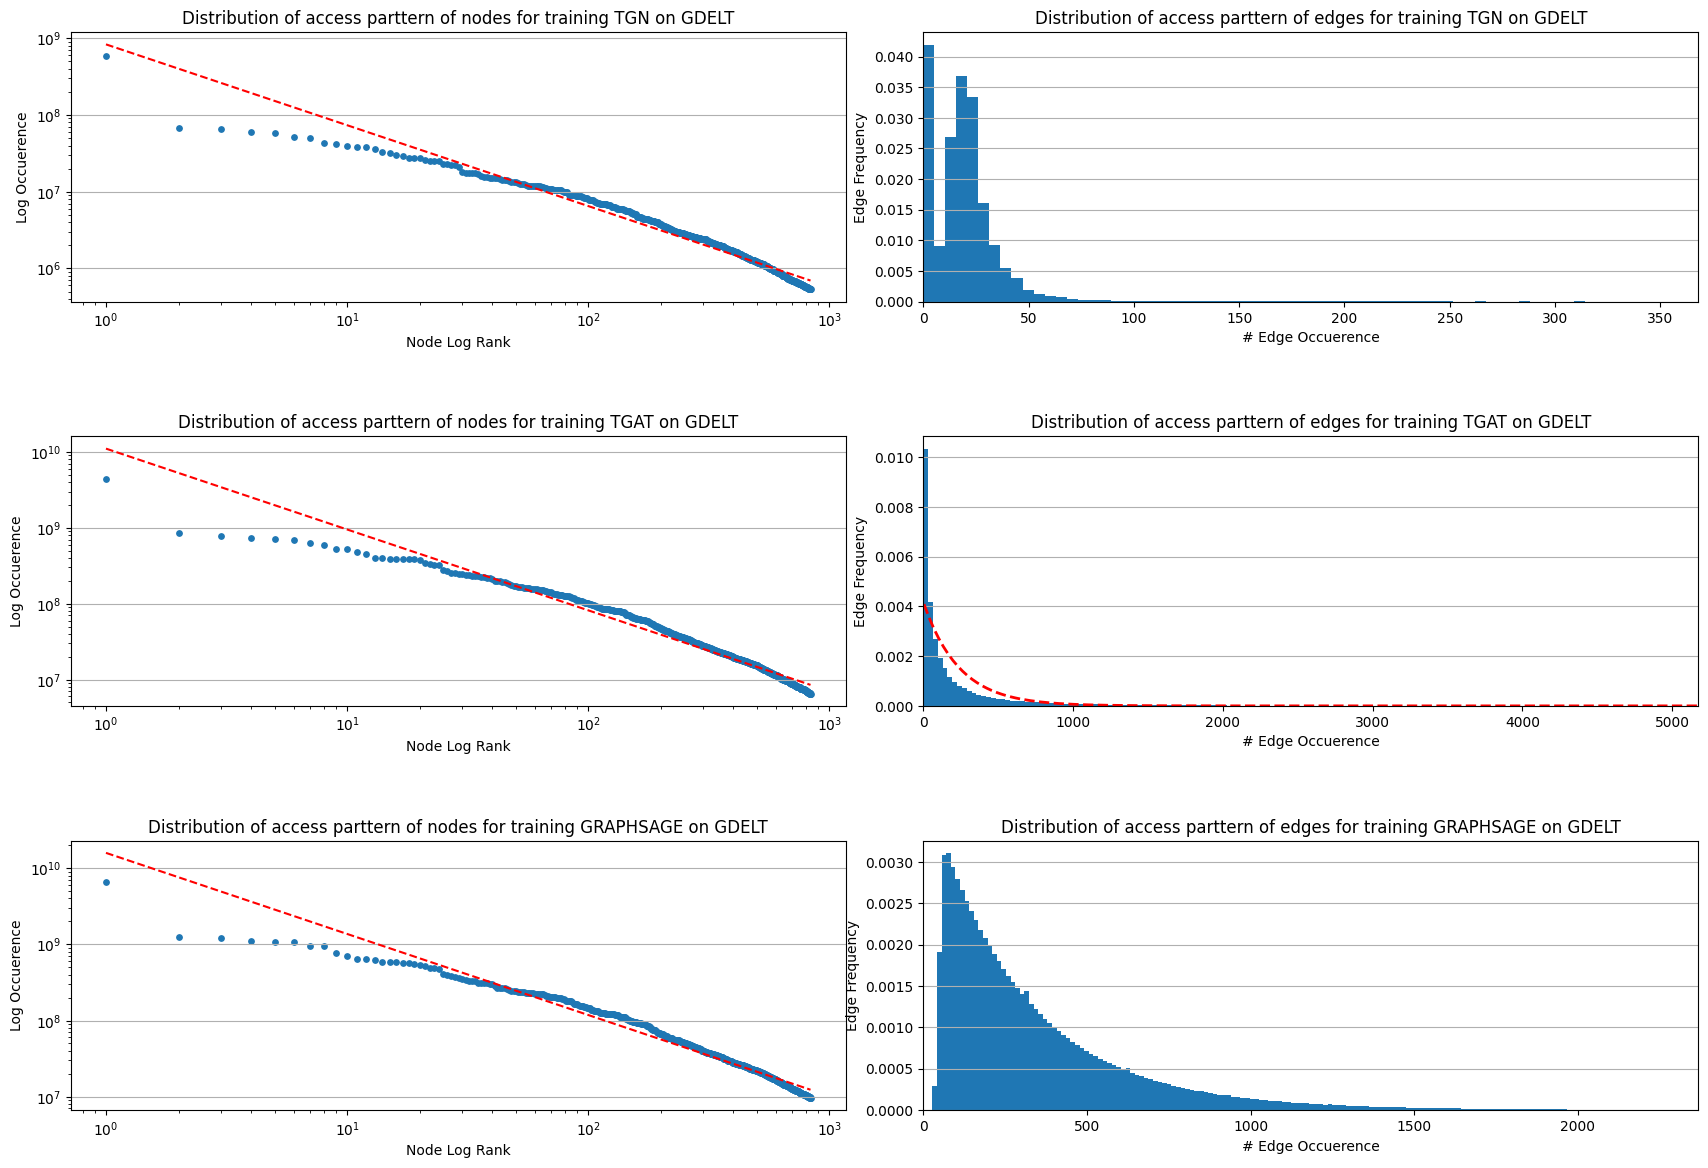

In [108]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import skew

import torch
import itertools

models = ['TGN', 'TGAT', 'GRAPHSAGE']
datasets = ['GDELT']


param_space = list(itertools.product(
    models, datasets))

nrow = len(param_space)
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(nrow*7, ncol*7))
# set margin
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for idx, param in enumerate(param_space):
    node_to_cnt = torch.load("{}_{}_node_to_cnt.pt".format(*param))
    edge_to_cnt = torch.load("{}_{}_edge_to_cnt.pt".format(*param))

    def log_rank_freq(data, ax, type):
        values = data.cpu().numpy()
        values = values[values > 0]
        values = np.sort(values)[::-1]
        cutoff = np.percentile(values, 95)
        values = values[values > cutoff]
        ranks = range(1, len(values)+1)

        x = np.log10(ranks)
        y = np.log10(values)
        
        coeffs = np.polyfit(x, y, 1)
        alpha = coeffs[0]
        C = 10**coeffs[1]
        print(alpha, coeffs[1])

        ax.scatter(ranks, values, s=15)

        x = np.logspace(np.log10(ranks[0]), np.log10(ranks[-1]), num=len(ranks))
        y = C * x**(alpha) 
        ax.loglog(x, y, linestyle='--', color='r')
        ax.grid(axis='y')
        ax.set_xlabel("Node Log Rank")
        ax.set_ylabel("Log Occuerence")
        ax.set_title("Distribution of access parttern of nodes for training {} on {}".format(*param))

    def hist(data, ax, label, model):
        data = data.cpu().numpy()
        print(np.max(data))
        ax.hist(data, bins=1000, density=True)
        ax.set_xlabel('# {} Occuerence'.format(label))
        ax.set_ylabel('{} Frequency'.format(label))
        cutoff = np.percentile(data, 99.9)
        print(cutoff)
        ax.set_xlim((0, cutoff))
        ax.grid(axis='y')
        ax.set_title("Distribution of access parttern of edges for training {} on {}".format(*param))

        if model == "TGN":
            pass
        elif model  == "TGAT":
            loc, scale = expon.fit(data)
            pdf = expon.pdf(np.linspace(5, max(data), 1000), loc, scale)
            ax.plot(np.linspace(5, max(data), 1000), pdf, 'r--', linewidth=2)
            print("lambda = {:.4f}".format(1/scale))
        elif model == "GRAPHSAGE":
            skew_param = skewnorm.fit(data)
            pdf = skewnorm.pdf(np.linspace(0, cutoff, 100), *skew_param)

            ax.plot(np.linspace(0, cutoff ,100), pdf, 'r-', linewidth=2)
        

    log_rank_freq(node_to_cnt, axes[idx][0], 'Node')
    hist(edge_to_cnt, axes[idx][1], 'Edge', param[0])

plt.show()